## Import Package

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

## Import Dataset

In [2]:
# Load data Master Kelas (untuk tahu estimasi jam belajar)
df_journeys = pd.read_excel('C:\Materi Kuliah\Semester 5 - Asah led by Dicoding with Accenture\Capstone Project\Dataset\developer_journeys.xlsx')

# Load data Tracking Aktivitas (untuk tahu kapan user buka modul)
df_trackings = pd.read_excel('C:\Materi Kuliah\Semester 5 - Asah led by Dicoding with Accenture\Capstone Project\Dataset\developer_journey_trackings.xlsx')

# Load data Penyelesaian Kelas (untuk tahu durasi user & jumlah re-enroll)
df_completions = pd.read_excel('C:\Materi Kuliah\Semester 5 - Asah led by Dicoding with Accenture\Capstone Project\Dataset\developer_journey_completions.xlsx')

## Feature Selection

In [ ]:
# Kolom yang dipakai untuk aktivitas adalah 'last_viewed' , cz 'first_opened_at' banyak yang kosong

def clean_indo_date(date_str):
    if pd.isna(date_str):
        return pd.NaT # Kembalikan Not-a-Time jika kosong

    # Pastikan data berbentuk string
    date_str = str(date_str)

    #  Mapping Bulan Indo -> Inggris
    replacements = {
        'Mei': 'May',
        'Agu': 'Aug',
        'Okt': 'Oct',
        'Des': 'Dec'
        # Jan, Feb, Mar, Apr, Jun, Jul, Sep, Nov biasanya sama atau mirip
    }
    for indo, eng in replacements.items():
        date_str = date_str.replace(indo, eng)

    # Ganti titik waktu (21.34) menjadi titik dua (21:34) agar standar
    # Logika: Ganti titik terakhir dengan titik dua jika formatnya HH.MM
    # Atau biarkan pandas menebak formatnya setelah bulan diganti
    return date_str

# Terapkan fungsi pembersih ke kolom last_viewed
df_trackings['date_clean'] = df_trackings['last_viewed'].apply(clean_indo_date)

# Convert ke datetime
df_trackings['activity_date'] = pd.to_datetime(df_trackings['date_clean'])

# Hapus baris yang gagal di-convert (jika ada data sampah)
df_trackings = df_trackings.dropna(subset=['activity_date'])

print("Format tanggal berhasil diperbaiki!")

Format tanggal berhasil diperbaiki!


In [4]:
# Hitung modul unik per hari
daily_activity = df_trackings.groupby(['developer_id', df_trackings['activity_date'].dt.date])['tutorial_id'].nunique().reset_index()
daily_activity.columns = ['user_id', 'date', 'daily_modules_count']

# Rata-rata modul per hari (Fast Learner Indicator)
avg_daily_modules = daily_activity.groupby('user_id')['daily_modules_count'].mean().reset_index()
avg_daily_modules.rename(columns={'daily_modules_count': 'avg_modules_per_day'}, inplace=True)

# Konsistensi / Std Dev (Consistent Learner Indicator)
consistency_score = daily_activity.groupby('user_id')['daily_modules_count'].std().fillna(0).reset_index()
consistency_score.rename(columns={'daily_modules_count': 'consistency_std_dev'}, inplace=True)

# Fitur REFLEKSI & TIME RATIO
# Gabung completion & journeys
merged_completion = pd.merge(df_completions, df_journeys, left_on='journey_id', right_on='id', how='left')

# Hitung Time Ratio (Durasi Belajar / Jam Estimasi)
# Tambah 0.001 biar tidak error pembagian nol
merged_completion['time_ratio'] = merged_completion['study_duration'] / (merged_completion['hours_to_study'] + 0.001)

# Agregasi per user
user_completion_stats = merged_completion.groupby('user_id').agg({
    'enrolling_times': 'sum',   # Total Re-enroll (Reflective)
    'time_ratio': 'mean'        # Avg Time Ratio
}).reset_index()

In [5]:
df_final = pd.merge(avg_daily_modules, consistency_score, on='user_id', how='outer')
df_final = pd.merge(df_final, user_completion_stats, on='user_id', how='left')
df_final = df_final.fillna(0)

# Tampilkan Hasil
print("Dataset Final\n")
print(df_final.head())

Dataset Final

   user_id  avg_modules_per_day  consistency_std_dev  enrolling_times  \
0     3390            12.762125            35.007159             67.0   
1     5774            16.322981            32.075225             25.0   
2    11836            13.686192            26.548945             63.0   
3    17833             9.069048            12.411308             49.0   
4    32258             8.829123            17.712794             88.0   

    time_ratio  
0     1.204715  
1     2.407703  
2     9.630199  
3     1.759105  
4  1398.793993  


In [6]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              31 non-null     int64  
 1   avg_modules_per_day  31 non-null     float64
 2   consistency_std_dev  31 non-null     float64
 3   enrolling_times      31 non-null     float64
 4   time_ratio           31 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 1.3 KB


### Visualisasi Distribusi

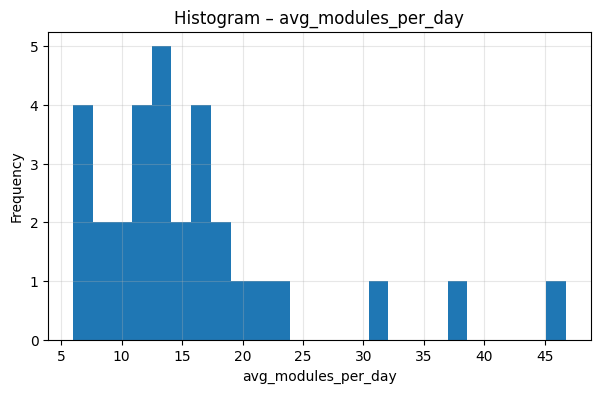

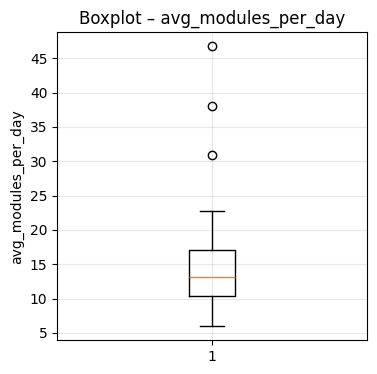

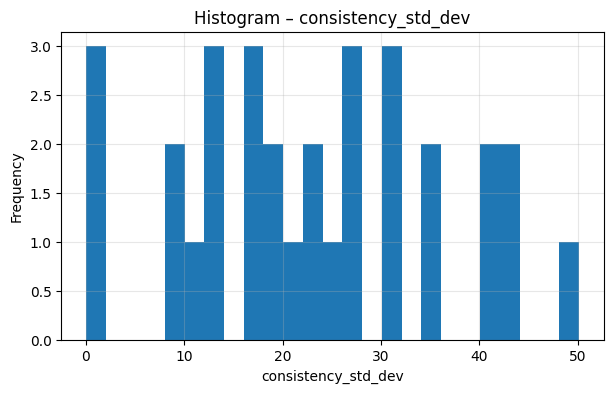

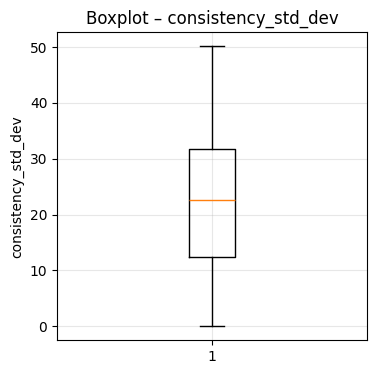

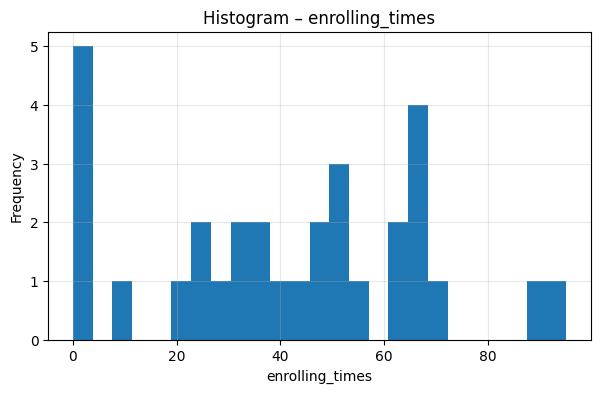

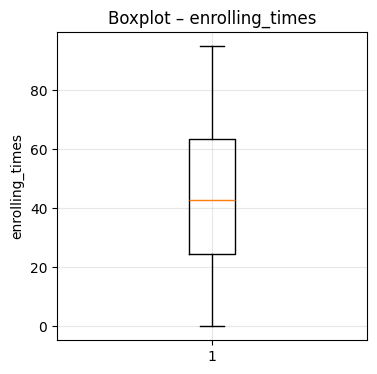

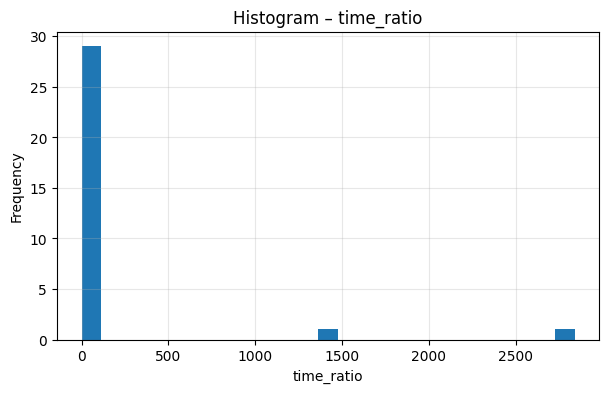

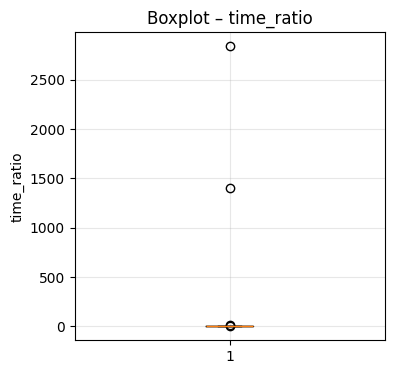

In [7]:
features = [
    "avg_modules_per_day",
    "consistency_std_dev",
    "enrolling_times",
    "time_ratio"
]

# Visualisasi distribusi setiap fitur

for col in features:
    # Histogram
    plt.figure(figsize=(7,4))
    plt.hist(df_final[col].dropna(), bins=25)
    plt.title(f"Histogram – {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.show()

    # Boxplot
    plt.figure(figsize=(4,4))
    plt.boxplot(df_final[col].dropna(), vert=True)
    plt.title(f"Boxplot – {col}")
    plt.ylabel(col)
    plt.grid(alpha=0.3)
    plt.show()

## Augementasi Data

In [8]:
df_clean = df_final.copy()

In [9]:
# Log transform untuk data yang jomplang
for col in ['enrolling_times', 'time_ratio']:
    df_clean[col] = np.log1p(df_clean[col])

X_original = df_clean[features].values
print(f"Data Awal: {len(X_original)} baris (31 User)")

Data Awal: 31 baris (31 User)


In [10]:
print("SMOTE")

# Augmentasi
# Butuh pseudo-label karena SMOTE perlu target class
kmeans_pseudo = KMeans(n_clusters=3, random_state=42).fit(X_original)
y_pseudo = kmeans_pseudo.labels_

# Target: 333 data per kelas
# Mengurangi k_neighbors menjadi 1 karena ada cluster dengan hanya 2 sampel.
smote = SMOTE(sampling_strategy={0:333, 1:333, 2:333}, k_neighbors=1, random_state=42)
X_total, _ = smote.fit_resample(X_original, y_pseudo)

print("Augmentasi Berhasil")

SMOTE
Augmentasi Berhasil


## Kmeans Clustering

In [11]:
# Scaling & Modeling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_total)
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled)

# Score
score3 = silhouette_score(X_scaled, kmeans.labels_)
print(f"📊 Silhouette Score: {score3:.4f}")

📊 Silhouette Score: 0.6306


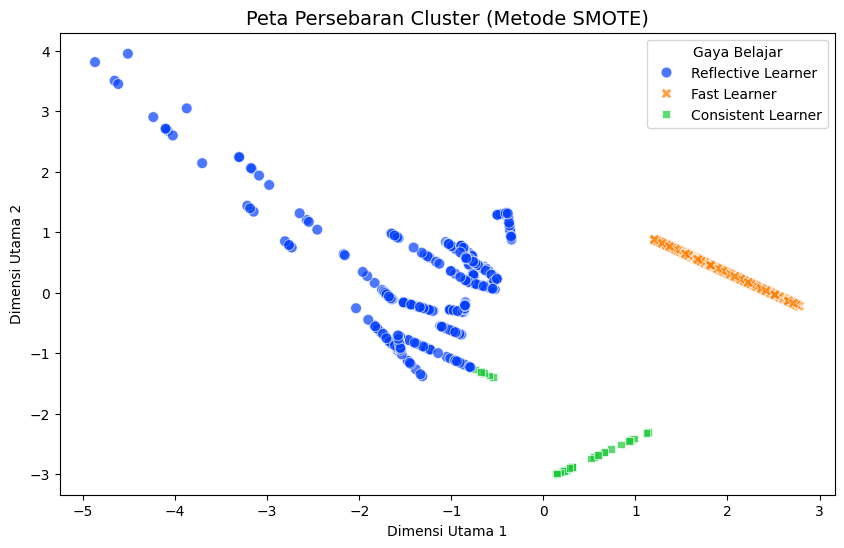

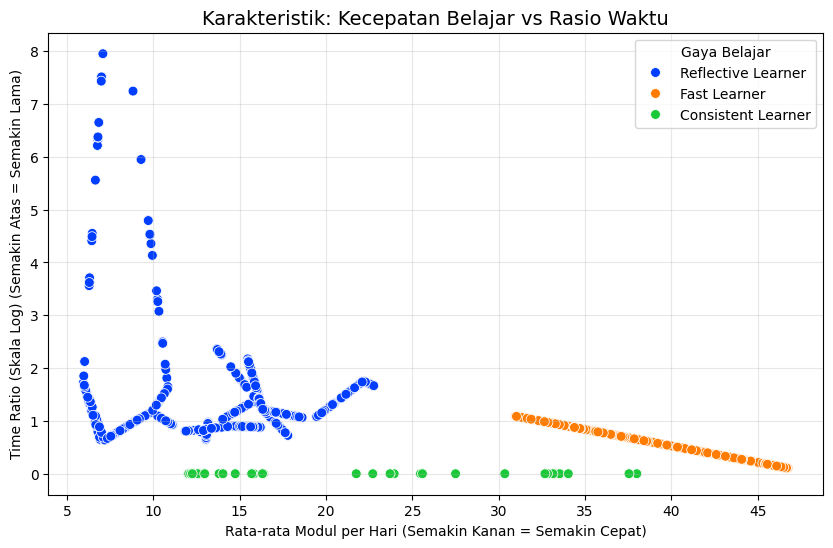

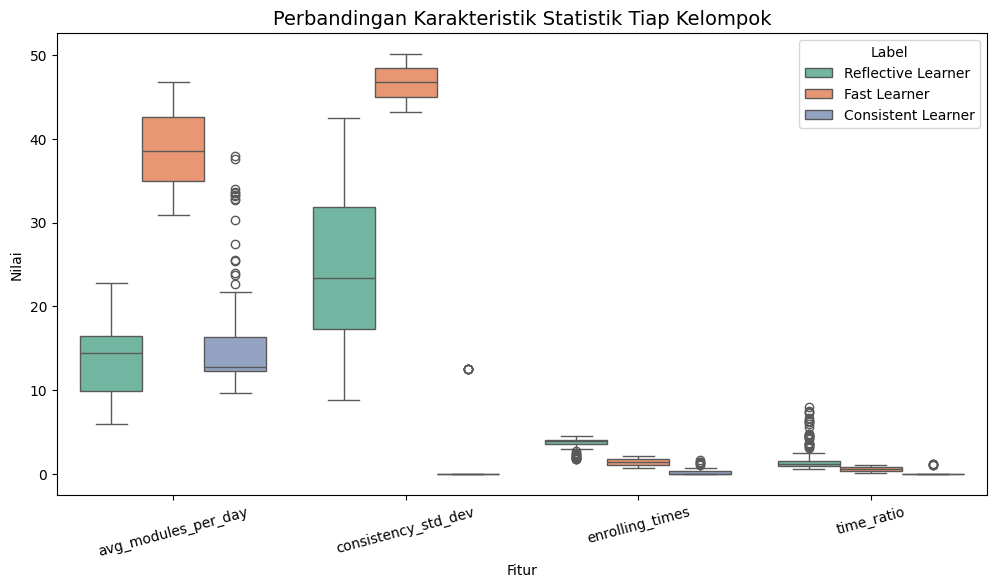

In [12]:
# DataFrame hasil SMOTE
# Corrected: Use X_total (SMOTE output) and kmeans.labels_
df_viz = pd.DataFrame(X_total, columns=features)
df_viz['Cluster_ID'] = kmeans.labels_ # Labels from K-Means after SMOTE

#  AUTO-MAPPING LABEL
# Define label_map by analyzing the cluster characteristics.
# We need to inverse log transform 'enrolling_times' and 'time_ratio' for human readability.
temp_df_for_labeling = df_viz.copy()
temp_df_for_labeling['enrolling_times_real'] = np.expm1(temp_df_for_labeling['enrolling_times'])
temp_df_for_labeling['time_ratio_real'] = np.expm1(temp_df_for_labeling['time_ratio'])

# Calculate mean of real values for each cluster
summary_for_labels = temp_df_for_labeling.groupby('Cluster_ID')[['avg_modules_per_day', 'consistency_std_dev', 'enrolling_times_real', 'time_ratio_real']].mean()

# Heuristic to assign labels based on typical learning styles
# This assumes the clusters broadly align with these categories
label_map = {}
# Find 'Reflective Learner' (highest time_ratio_real)
reflective_cluster = summary_for_labels['time_ratio_real'].idxmax()
label_map[reflective_cluster] = 'Reflective Learner'

# Find 'Fast Learner' among remaining (highest avg_modules_per_day)
remaining_clusters = summary_for_labels.index.drop(reflective_cluster)
if not remaining_clusters.empty:
    fast_cluster = summary_for_labels.loc[remaining_clusters, 'avg_modules_per_day'].idxmax()
    label_map[fast_cluster] = 'Fast Learner'
    remaining_clusters = remaining_clusters.drop(fast_cluster)

# The last remaining cluster is 'Consistent Learner'
if not remaining_clusters.empty:
    consistent_cluster = remaining_clusters[0]
    label_map[consistent_cluster] = 'Consistent Learner'

df_viz['Label'] = df_viz['Cluster_ID'].map(label_map)

# GRAFIK 1: PCA (PETA PERSEBARAN GLOBAL)
# Ini merangkum 4 dimensi menjadi 2 dimensi (Peta Datar)
pca = PCA(n_components=2)
# Corrected: Use X_scaled (scaled data after SMOTE) for PCA
pca_result = pca.fit_transform(X_scaled)

df_viz['PC1'] = pca_result[:, 0]
df_viz['PC2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_viz, x='PC1', y='PC2',
    hue='Label', style='Label',
    palette='bright', s=60, alpha=0.7
)
plt.title('Peta Persebaran Cluster (Metode SMOTE)', fontsize=14)
plt.xlabel('Dimensi Utama 1')
plt.ylabel('Dimensi Utama 2')
plt.legend(title='Gaya Belajar')
plt.show()

# GRAFIK 2: KECEPATAN VS WAKTU (PEMBEDA UTAMA)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_viz,
    x='avg_modules_per_day',
    y='time_ratio', # Ingat: Ini masih skala Logaritma
    hue='Label',
    palette='bright', s=50
)
plt.title('Karakteristik: Kecepatan Belajar vs Rasio Waktu', fontsize=14)
plt.xlabel('Rata-rata Modul per Hari (Semakin Kanan = Semakin Cepat)')
plt.ylabel('Time Ratio (Skala Log) (Semakin Atas = Semakin Lama)')
plt.legend(title='Gaya Belajar')
plt.grid(True, alpha=0.3)
plt.show()

# GRAFIK 3: BOXPLOT (DETAIL STATISTIK)

# Kita un-pivot data biar bisa dibikin boxplot sekaligus
df_melted = df_viz.melt(id_vars=['Label', 'Cluster_ID'],
                        value_vars=features,
                        var_name='Fitur', value_name='Nilai')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x='Fitur', y='Nilai', hue='Label', palette='Set2')
plt.title('Perbandingan Karakteristik Statistik Tiap Kelompok', fontsize=14)
plt.xticks(rotation=15)
plt.show()

## Import Model

In [13]:
# import joblib

# # Simpan Model K-Means
# joblib.dump(kmeans, 'kmeans_model_final.joblib')

# # Simpan Scaler (INI WAJIB ADA)
# # Scaler ini berisi rumus matematika untuk mengubah data user baru
# # agar sesuai dengan format yang dimengerti model.
# joblib.dump(scaler, 'scaler_final.joblib')

# print("Berhasil disimpan!")
# print("Silakan cek folder 'Files' di kiri Colab dan download kedua file tersebut.")

In [ ]:
import joblib

# Analisis Karakteristik Cluster (Untuk menentukan siapa 0, 1, 2)
#Butuh nilai asli (bukan scaled) untuk membaca karakteristik
# Karena tadi X_total adalah data hasil SMOTE (sudah log transform di awal),
# Perlu inverse log transform untuk kolom 'enrolling' & 'time_ratio' agar mudah dibaca

df_analysis = pd.DataFrame(scaler.inverse_transform(X_scaled), columns=features)
df_analysis['Cluster'] = kmeans.labels_

# Hitung rata-rata per cluster
cluster_means = df_analysis.groupby('Cluster').mean()
print("\nRATA-RATA STATISTIK PER CLUSTER")
print(cluster_means)

# Logika Otomatis Penentuan Label
# Cari cluster dengan time_ratio paling tinggi (setelah di-inverse log) -> Reflective
# Cari cluster dengan speed paling tinggi -> Fast
# Sisanya -> Consistent

# Pakai nilai dari dataframe analisis
reflective_id = cluster_means['time_ratio'].idxmax()
fast_id = cluster_means['avg_modules_per_day'].idxmax()

# Cluster sisa adalah Consistent
all_ids = {0, 1, 2}
consistent_id = list(all_ids - {reflective_id, fast_id})[0]

label_mapping = {
    reflective_id: 'Reflective Learner',
    fast_id: 'Fast Learner',
    consistent_id: 'Consistent Learner'
}

print("\nHASIL MAPPING OTOMATIS")
for cid, label in label_mapping.items():
    print(f"Cluster {cid} = {label}")

# Simpan Model & Scaler untuk Backend
joblib.dump(kmeans, 'kmeans_model_final.joblib')
joblib.dump(scaler, 'scaler_final.joblib')

print("\n✅ Model berhasil disimpan sebagai 'kmeans_model_final.joblib'")
print("✅ Scaler berhasil disimpan sebagai 'scaler_final.joblib'")


--- RATA-RATA STATISTIK PER CLUSTER ---
         avg_modules_per_day  consistency_std_dev  enrolling_times  time_ratio
Cluster                                                                       
0                  38.596131            46.789972         1.470225    0.613888
1                  13.798060            24.484827         3.798902    1.399379
2                  16.764272             1.055351         0.235909    0.096087

HASIL MAPPING OTOMATIS
Cluster 1 = Reflective Learner
Cluster 0 = Fast Learner
Cluster 2 = Consistent Learner

✅ Model berhasil disimpan sebagai 'kmeans_model_final.joblib'
✅ Scaler berhasil disimpan sebagai 'scaler_final.joblib'
